In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, precision_recall_curve, auc, precision_score,
                             PrecisionRecallDisplay, RocCurveDisplay)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 0. Загрузка данных

In [2]:
df = pd.read_csv('../content/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 1. Базовое решение

### 1.1 Минимальные преобразования

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

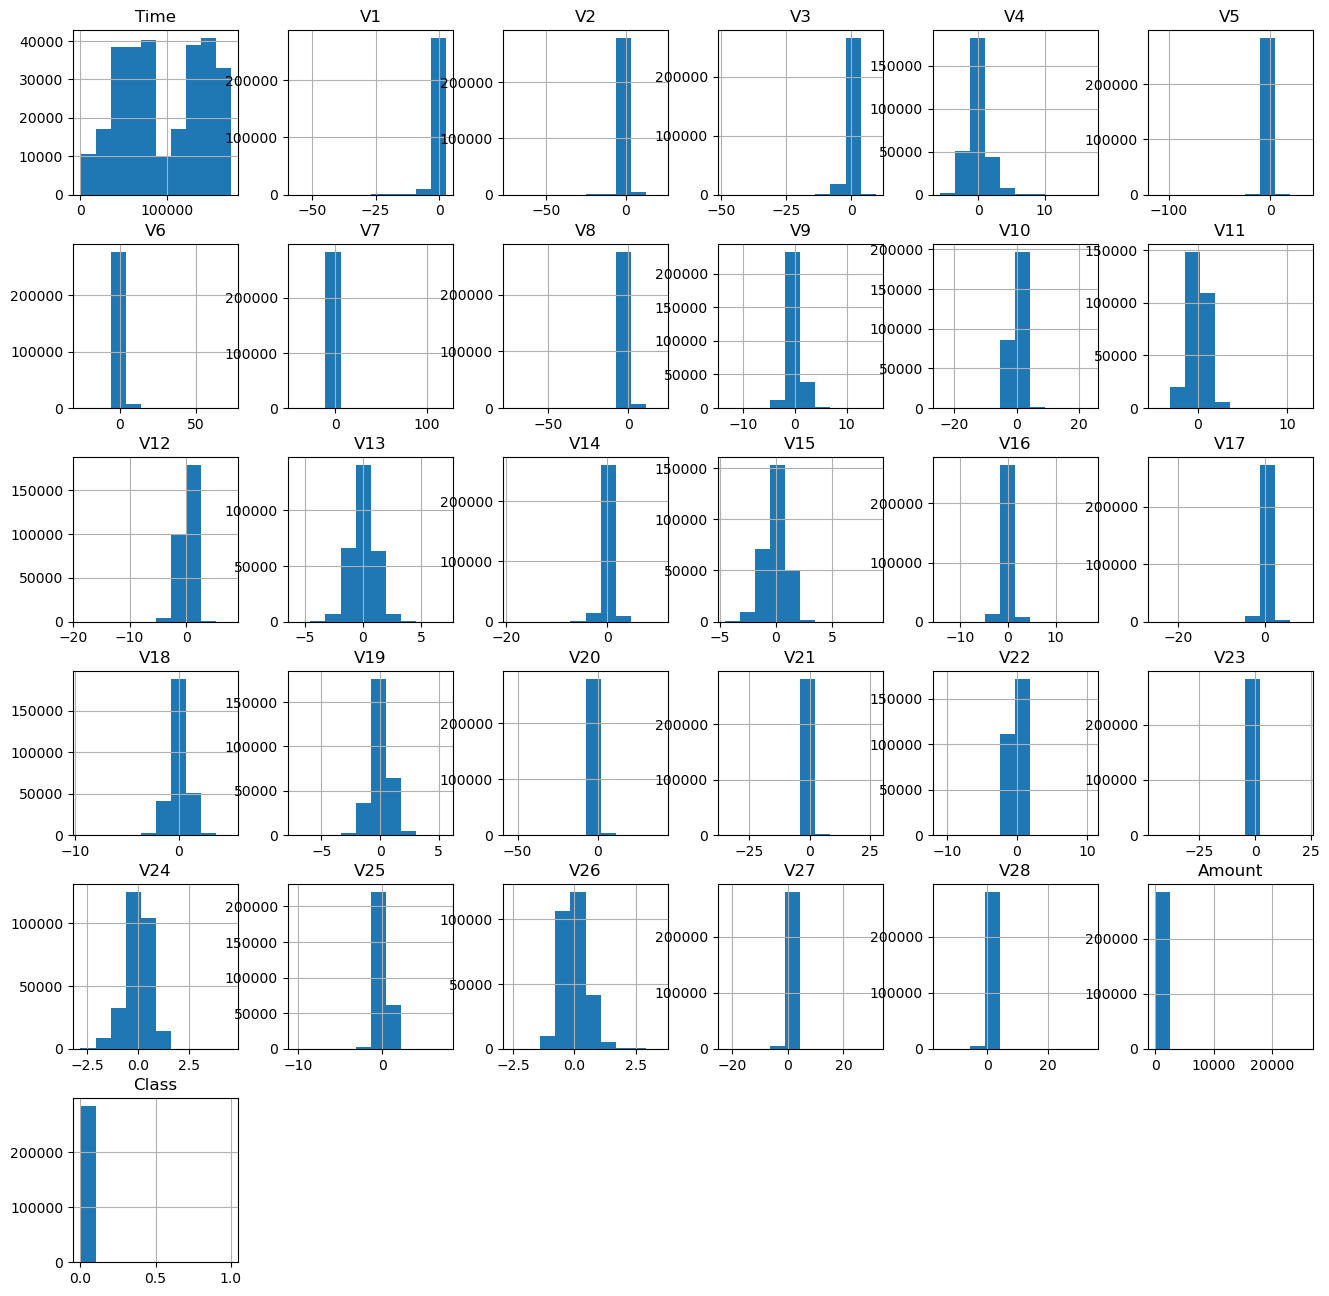

In [4]:
df.hist(figsize=(16, 16));

Практически все признаки имеют выбросы, но сильнее всего перекос в данных имеется в признаке `Amount`

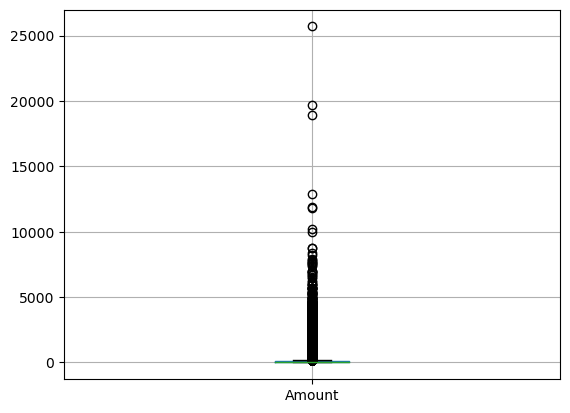

In [5]:
df.boxplot(['Amount']);

In [6]:
IQR = df['Amount'].quantile(.75) - df['Amount'].quantile(.25)
amount_max = df['Amount'].quantile(.75) + 1.5 * IQR
amount_min = df['Amount'].quantile(.25) - 1.5 * IQR

df.loc[(df['Amount'] > amount_max) | (df['Amount'] < amount_min), 'Amount'] = df['Amount'].mean()

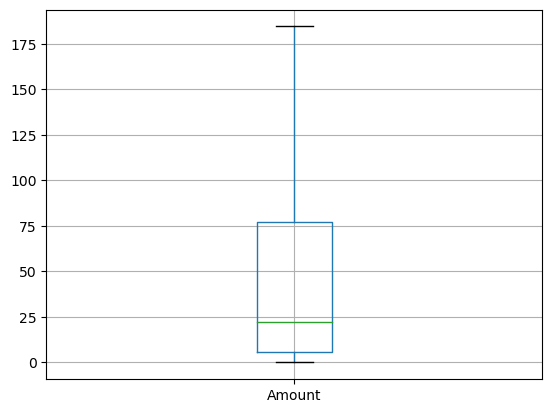

In [7]:
df.boxplot(['Amount']);

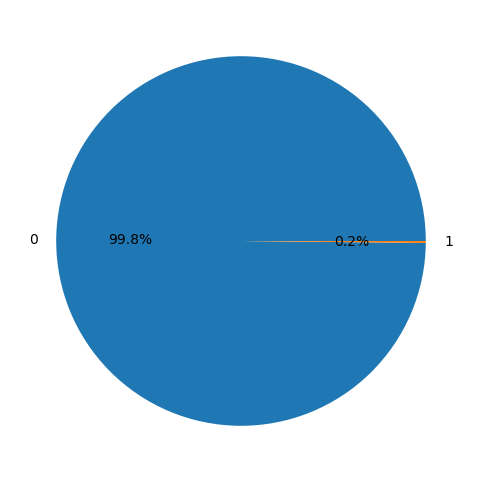

In [8]:
class_counts_df = df["Class"].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(class_counts_df.values
        , labels=class_counts_df.index
        , autopct='%.1f%%'
        );

### 1.2 Обучение модели

In [9]:
X = df.drop(columns='Class')
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,             # применим из-за дисбаланса классов
                                                    random_state=42)
X_train.shape, X_test.shape

((227845, 30), (56962, 30))

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [11]:
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)
pred_proba_test = lr.predict_proba(X_test)

### 1.3 Подсчет метрик качества

In [12]:
# для train'а
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.75      0.65      0.70       394

    accuracy                           1.00    227845
   macro avg       0.88      0.82      0.85    227845
weighted avg       1.00      1.00      1.00    227845



In [13]:
# для test'а
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.69      0.70        98

    accuracy                           1.00     56962
   macro avg       0.86      0.85      0.85     56962
weighted avg       1.00      1.00      1.00     56962



<Figure size 1200x1000 with 0 Axes>

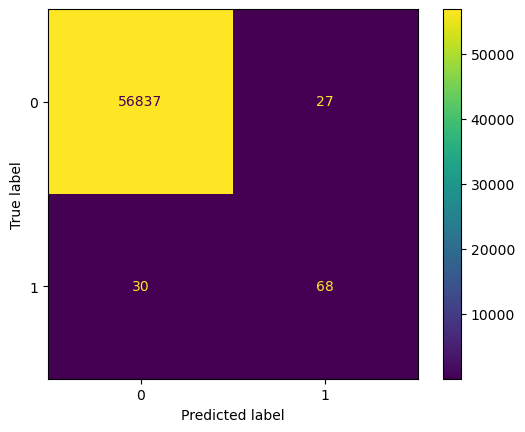

In [14]:
# матрица ошибок
plt.figure(figsize=(12, 10))

cm = confusion_matrix(y_test, pred_test, labels=lr.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
display.plot()
plt.show();

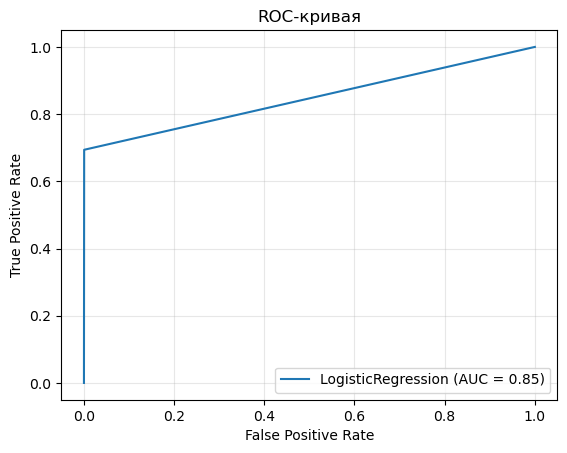

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
display = RocCurveDisplay(fpr=fpr, tpr=tpr
                          , roc_auc=auc(fpr, tpr)
                          , estimator_name='LogisticRegression')
display.plot()
plt.title('ROC-кривая')
plt.grid(True, alpha=.3)
plt.show()

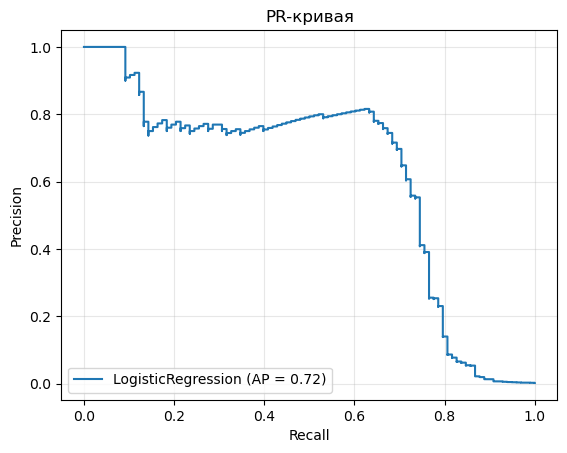

In [16]:
pr, r, _ = precision_recall_curve(y_test, pred_proba_test[:, 1])            # для класса 1

display = PrecisionRecallDisplay(precision=pr, recall=r
                                 , average_precision=precision_score(y_test, pred_test)
                                 , estimator_name='LogisticRegression')
display.plot()
plt.title("PR-кривая")
plt.grid(True, alpha=.3)
plt.show()

## 2. Разделение данных на обучающие и тестовые

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=42)
X_train.shape, X_test.shape

((227845, 30), (56962, 30))

In [18]:
y_train.value_counts(normalize=True)

0    0.998271
1    0.001729
Name: Class, dtype: float64

In [19]:
y_test.value_counts(normalize=True)

0    0.99828
1    0.00172
Name: Class, dtype: float64

## 3. Балансировка данных минимум тремя методами

In [20]:
def balance_df_by_target(df, target_idx, method='over'):
    # df здесь - numpy-массив

    assert method in ['over', 'under', 'smote'], 'Неверный метод сэмплирования'

    df[target_idx] = df[target_idx].astype('int')
    target_counts = df[target_idx].value_counts()       # перевели в DataFrame

    major_class_name = target_counts.argmax()           # имя класса с бОльшим количеством объектов
    minor_class_name = target_counts.argmin()           # имя класса с меньшим количеством объектов
    
    # во сколько раз большего класса больше, чем меньшего
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for _ in range(disbalance_coeff):
            sample = df[df[target_idx] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)

    elif method == 'under':
        df_ = df.copy()                     # на всякий случай работаем с копией
        df = df_[df_[target_idx] == minor_class_name]
        tmp = df_[df_[target_idx] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'smote':
        # генерация синтетических данных
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_idx), df[target_idx])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1)

In [21]:
import numpy as np

# преобразование обучающих данных в конкатенацию вдоль второй оси (по столбцам) - датасет тренировочных данных для балансировки
df_for_balancing = pd.DataFrame(np.c_[X_train, y_train.values])
df_for_balancing.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,161919.0,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,1.406819,...,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,7.32,0.0
1,124477.0,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,0.045826,...,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,2.99,0.0
2,41191.0,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,0.000772,...,-2.798352,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,175.10,0.0
3,132624.0,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,-1.118447,...,-0.139670,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,6.10,0.0
4,59359.0,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,-0.044782,...,-0.243245,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,86.10,0.0


In [22]:
TARGET_NAME = 30

### 3.1 Балансировка методом oversampling

In [23]:
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')

df_balanced[TARGET_NAME].value_counts()

0    227451
1    227338
Name: 30, dtype: int64

In [24]:
# степень расхождения классов
print(f"{df_balanced[TARGET_NAME].value_counts()[1] / df_balanced[TARGET_NAME].value_counts()[0]:.5f}")

0.99950


### 3.2 Балансировка методом undersampling

In [25]:
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')

df_balanced[TARGET_NAME].value_counts()

1    394
0    394
Name: 30, dtype: int64

In [26]:
# степень расхождения классов
print(f"{df_balanced[TARGET_NAME].value_counts()[1] / df_balanced[TARGET_NAME].value_counts()[0]:.5f}")

1.00000


### 3.3 Балансировка методом `SMOTE`

In [27]:
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')

df_balanced[TARGET_NAME].value_counts()

0    227451
1    227451
Name: 30, dtype: int64

In [28]:
# степень расхождения классов
print(f"{df_balanced[TARGET_NAME].value_counts()[1] / df_balanced[TARGET_NAME].value_counts()[0]:.5f}")

1.00000


## 4. Обучение модели классификации с целевым признаком `CLass`

In [29]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [30]:
lr = LogisticRegression()
lr.fit(X_train_balanced, y_train_balanced)
pred_train = lr.predict(X_train_balanced)
pred_test = lr.predict(X_test)
pred_proba_test = lr.predict_proba(X_test)

## 5. Оценка метрик качества

<Figure size 1200x1000 with 0 Axes>

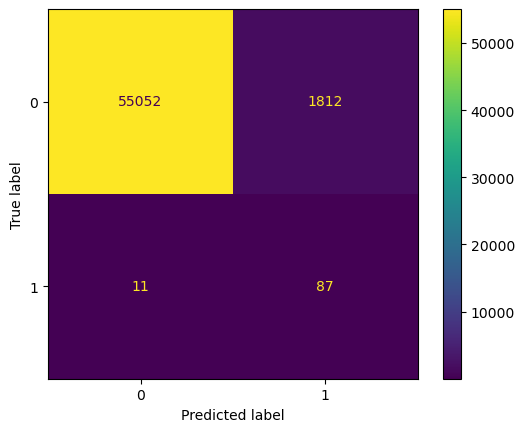

In [31]:
# матрица ошибок
plt.figure(figsize=(12, 10))

cm = confusion_matrix(y_test, pred_test, labels=lr.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
display.plot()
plt.show();

In [32]:
# для train'а
print(classification_report(y_train_balanced, pred_train))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96    227451
           1       0.97      0.94      0.96    227451

    accuracy                           0.96    454902
   macro avg       0.96      0.96      0.96    454902
weighted avg       0.96      0.96      0.96    454902



In [33]:
# для test'а
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.89      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.93      0.54     56962
weighted avg       1.00      0.97      0.98     56962



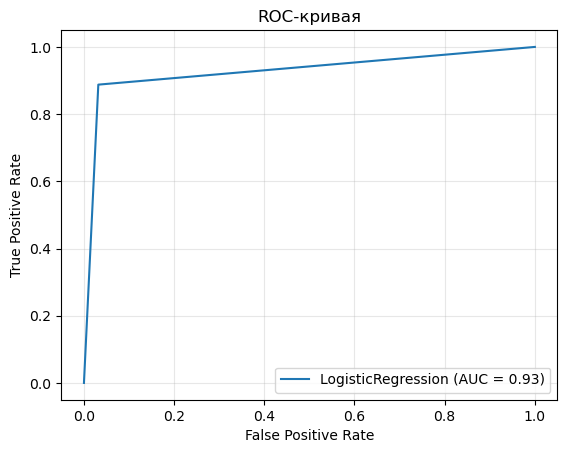

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
display = RocCurveDisplay(fpr=fpr, tpr=tpr
                          , roc_auc=auc(fpr, tpr)
                          , estimator_name='LogisticRegression')
display.plot()
plt.title('ROC-кривая')
plt.grid(True, alpha=.3)
plt.show()

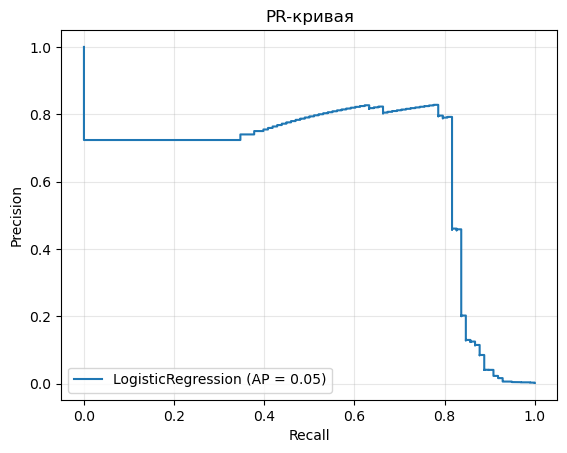

In [35]:
pr, r, _ = precision_recall_curve(y_test, pred_proba_test[:, 1])            # для класса 1

display = PrecisionRecallDisplay(precision=pr, recall=r
                                 , average_precision=precision_score(y_test, pred_test)
                                 , estimator_name='LogisticRegression')
display.plot()
plt.title("PR-кривая")
plt.grid(True, alpha=.3)
plt.show()

## 6. Выводы о проделанной работе

**Базовое решение:**

F1-score (для теста, макроусреднённая) равна **0.85**. Площадь под ROC-кривой - **0.85**. Средняя точность - **0.72**.

**Решение с балансировкой целевого признака:**

F1-score (для трейна, макроусреднённая) равна **0.96**, F1-score (для теста, макроусреднённая) равна **0.54**, . Площадь под ROC-кривой - **0.93**. Средняя точность - **0.05**.


Модель стала заметно лучше работать на обучающих данных по причине того, что они были сбалансированы, а на тесте показала результаты хуже, посколько тестовые данные сбалансированы не были